# Classification

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats
from preprocessing import *
from config import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
plt.style.use("fivethirtyeight")
np.random.seed(42)

## Load data

In [3]:
track_length = 16

In [4]:
y = np.load(rf'data_files\labels_All{track_length}.npy')
x = np.load(rf'data_files\features_All{track_length}.npy')
print(x.shape, y.shape)

(29808, 16, 5) (29808,)


In [5]:
y2treat = pd.Series(y).map(wells_to_genetype_dict)
y2treat = pd.DataFrame(y2treat)

<AxesSubplot:xlabel='0'>

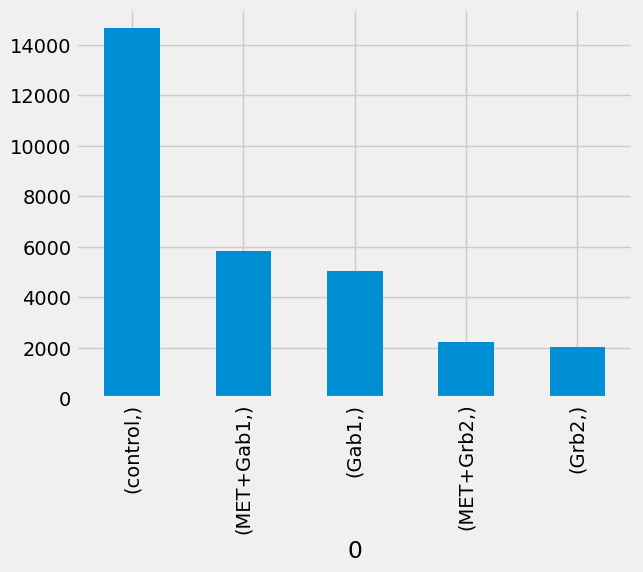

In [6]:
y2treat.value_counts().plot.bar()

In [7]:
y2treat.groupby(0).size().min()

2017

In [11]:
y_treat_sample = y2treat.groupby(0).sample(2000)
y_treat_sample.shape

(10000, 1)

In [12]:
y_sample = y[y_treat_sample.index.values]
y_sample.shape

(10000,)

In [13]:
x_sample = x[y_treat_sample.index.values]
x_sample.shape

(10000, 16, 5)

In [14]:
np.save('x_balanced_sample_16.npy',x_sample)
np.save('y_balanced_sample_16.npy',y_sample)

## Normalize

In [15]:
x_norm , scaler= normalize_axis(x_sample)
x_norm.shape

(10000, 16, 5)

In [30]:
from keras.models import Model, Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D
from keras.layers.core import Dense, Dropout, Flatten, Reshape
from keras.layers import Input, LSTM, UpSampling1D
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.layers import BatchNormalization, Activation
import keras.backend as K

def xy_ts_rnn_model(t, n_channels=2, n_classes=2, do_rate=0.3, reg=None, min_dim=128):
    '''
    Accepts X, Y time series as input, performs 1D convs with an LSTM layer and
    classifies

    Parameters
    ----------
    t : integer.
        length of time series.
    n_channels : integer.
        number of channels in data.
    n_classes : integer.
        number of output classes.
    reg : callable or None.
        regularizer.

    Returns
    -------
    model : keras model object.
    '''

    x = Input(shape=(t, n_channels))

    cv1 = Conv1D(16, 3, padding='same', activation='relu', activity_regularizer=reg)(x)
    cv2 = Conv1D(16, 3, padding='same', activation='relu', activity_regularizer=reg)(cv1)
    cv3 = Conv1D(32, 3, padding='same', activation='relu', activity_regularizer=reg)(cv2)
    cv4 = Conv1D(32, 3, padding='same', activation='relu', activity_regularizer=reg)(cv3)
    p1 = MaxPooling1D(pool_size=2)(cv4)

    lstm = LSTM(min_dim, dropout=0.2, recurrent_dropout=0.2)(p1)

    d1 = Dense(min_dim, activation='relu')(lstm)
    do1 = Dropout(rate=do_rate)(d1)
    d2 = Dense(min_dim//2, activation='relu')(do1)
    do2 = Dropout(rate=do_rate)(d2)

    classif = Dense(n_classes, activation='softmax')(do2)

    model = Model(x, classif)

    return model

In [17]:
le = LabelEncoder()
y2treat = pd.Series(y_sample).map(wells_to_genetype_dict)
y_lab = le.fit_transform(y2treat)
y_lab

array([0, 0, 0, ..., 4, 4, 4])

In [65]:
model = xy_ts_rnn_model(t = 16, n_channels=2, n_classes=5, do_rate=0.5, reg=None, min_dim=256)

In [66]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [67]:
callbacks = [EarlyStopping(patience=10, monitor='val_loss')]

In [72]:
X_train,X_test,y_train,y_test = train_test_split(x_norm[:,:,:2], y_lab, test_size=0.3, random_state=42)

In [69]:
X_train.shape

(7000, 16, 2)

In [70]:
y_train.shape

(7000,)

In [73]:
batch_size = 64
model.fit(
    X_train, y_train,
    batch_size=batch_size,
    shuffle=True,
    epochs=1000,
    validation_data=(X_test, y_test),
    callbacks=callbacks)

Epoch 1/1000
110/110 [==============================] - 3s 27ms/step - loss: 1.6334 - accuracy: 0.1994 - val_loss: 1.6101 - val_accuracy: 0.1963
Epoch 2/1000
110/110 [==============================] - 3s 26ms/step - loss: 1.6101 - accuracy: 0.2061 - val_loss: 1.6092 - val_accuracy: 0.1960
Epoch 3/1000
110/110 [==============================] - 3s 27ms/step - loss: 1.6096 - accuracy: 0.1989 - val_loss: 1.6090 - val_accuracy: 0.2010
Epoch 4/1000
110/110 [==============================] - 3s 28ms/step - loss: 1.6090 - accuracy: 0.2104 - val_loss: 1.6081 - val_accuracy: 0.2010
Epoch 5/1000
110/110 [==============================] - 3s 29ms/step - loss: 1.6065 - accuracy: 0.2240 - val_loss: 1.6042 - val_accuracy: 0.2283
Epoch 6/1000
110/110 [==============================] - 3s 27ms/step - loss: 1.5879 - accuracy: 0.2633 - val_loss: 1.5711 - val_accuracy: 0.2620
Epoch 7/1000
110/110 [==============================] - 3s 28ms/step - loss: 1.5180 - accuracy: 0.3293 - val_loss: 1.5062 - val_ac

In [48]:
y_pred = np.argmax(model.predict(X_test),axis=1)
y_pred

array([1, 3, 2, ..., 0, 3, 1], dtype=int64)

In [54]:
idx_True = np.where(y_test == y_pred)[0]
idx_True.shape

(1073,)

In [57]:
X_true = X_test[idx_True]

In [59]:
y_true_conf = np.max(model.predict(X_true),axis=1)


array([0.46245164, 0.26113105, 0.25382185, ..., 0.33869025, 0.3015187 ,
       0.67433363], dtype=float32)

<AxesSubplot:>

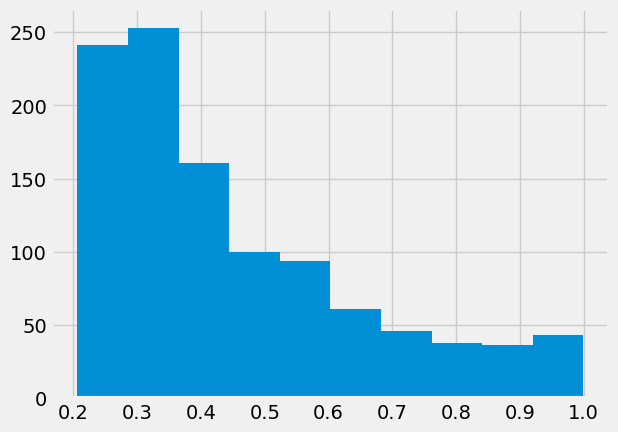

In [60]:
pd.Series(y_true_conf).hist()

In [62]:
len(y_true_conf[y_true_conf>0.5])

339